In [4]:
import spacy
from spacy import displacy
from spacy.tokens import DocBin
from tqdm import tqdm 
from spacy.util import filter_spans


In [1]:
!python -m spacy download en_core_web_trf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 5.7 MB/s eta 0:00:0000:0100:02


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.3/703.3 kB 36.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [5]:
nlp  = spacy.load('en_core_web_trf')

In [6]:
nlp.pipe_names


['transformer', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [10]:
text = "On 3rd Feb, Ram was in Delhi.\nLater he traveled to Mumbai via Air India flight reading a Time magazine to meet Raj.\nAfter 10 days, he went again back to Delhi wearing a Timex watch."
doc = nlp(text)
displacy.render(doc, style = 'ent')

In [12]:
# Test for medical terms

text_med =  "Antiretroviral therapy (ART) is recommended for all HIV-infected individuals to reduce the risk of disease progression."
doc_med = nlp(text_med)
displacy.render(doc_med, style = 'ent')

/Users/ashwin.s/anaconda3/lib/python3.11/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


### Above model(transformer) is not renderring the medical term 

- Medical NER dataset is a manually tagged data (diseases, pathogens, and medication) for training NER system.

- This dataset was created to train a spaCy model to perform Named Entity Recognition for three categories:

- Medical condition names (eg.: influenza, headache, malaria)
- Medicine names (eg.: aspirin, penicillin, ribavirin, methotrexate)
- Pathogens ( eg.: Corona Virus, Zika Virus, cynobacteria, E. Coli)

In spaCy, these character offsets are often used to create a Span object from a Doc using the char_span method, which maps character positions to token indices. This is useful for linking annotations or matches back to their exact position in the source text.

spaCy uses DocBin class for annotated data, so we'll have to create the DocBin objects for our training examples. This DocBin class efficiently serializes the information from a collection of Doc objects. It is faster and produces smaller data sizes than pickle, and allows the user to deserialize without executing arbitrary Python code.

- Creating a char_span is important for the training process text, span(start, end), label this is needed for the training process.
- Which means this text indicates this specific entity. (Thats why spanning is important)

In [24]:
import json 


In [25]:
path = "/Users/ashwin.s/Desktop/Medical NER/Corona2.json"

In [26]:
# load from the json file 

with open(path, "r") as f:
    data = json.load(f)

In [30]:
data.keys() # keys will be in the array
len((data['examples']))

31

In [34]:
obj_rough = data["examples"][0]
obj_rough['content']

"While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\n\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\n\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]"

In [35]:
# Getting the annotations
data['examples'][0]['annotations'][0]

{'id': '0825a1bf-6a6e-4fa2-be77-8d104701eaed',
 'tag_id': 'c06bd022-6ded-44a5-8d90-f17685bb85a1',
 'end': 371,
 'start': 360,
 'example_id': '18c2f619-f102-452f-ab81-d26f7e283ffe',
 'tag_name': 'Medicine',
 'value': 'Diosmectite',
 'correct': None,
 'human_annotations': [{'timestamp': '2020-03-21T00:24:32.098000Z',
   'annotator_id': 1,
   'tagged_token_id': '0825a1bf-6a6e-4fa2-be77-8d104701eaed',
   'name': 'Ashpat123',
   'reason': 'exploration'}],
 'model_annotations': []}

In [141]:
data['examples']

[{'id': '18c2f619-f102-452f-ab81-d26f7e283ffe',
  'content': "While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\n\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\n\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]",
  'metadata': {},
  'annotations': [{'id': '08

In [36]:
data['examples'][0]['annotations'][0].keys()

dict_keys(['id', 'tag_id', 'end', 'start', 'example_id', 'tag_name', 'value', 'correct', 'human_annotations', 'model_annotations'])

In [37]:
training_data = []
# trying to simplify the data set and then remove the unwanted key value pair
for example in data['examples']:
    temp_dict = {}
    temp_dict['text'] = example['content']
    temp_dict['entities'] = []
    
    for annotation in example['annotations']:
        start = annotation['start']
        end = annotation['end']
        
        label = annotation['tag_name'].upper()
        temp_dict['entities'].append((start, end, label))
    training_data.append(temp_dict)
    
print(training_data[0])

{'text': "While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\n\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\n\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]", 'entities': [(360, 371, 'MEDICINE'), (383, 408, 'MEDICINE'), (104, 112, 'MEDICALCONDITION'), (679,

In [41]:
training_data[0]['entities']

[(360, 371, 'MEDICINE'),
 (383, 408, 'MEDICINE'),
 (104, 112, 'MEDICALCONDITION'),
 (679, 689, 'MEDICINE'),
 (6, 23, 'MEDICINE'),
 (25, 37, 'MEDICINE'),
 (461, 470, 'MEDICALCONDITION'),
 (577, 589, 'MEDICINE'),
 (853, 865, 'MEDICALCONDITION'),
 (188, 198, 'MEDICINE'),
 (754, 762, 'MEDICALCONDITION'),
 (870, 880, 'MEDICALCONDITION'),
 (823, 833, 'MEDICINE'),
 (852, 853, 'MEDICALCONDITION'),
 (461, 469, 'MEDICALCONDITION'),
 (535, 543, 'MEDICALCONDITION'),
 (692, 704, 'MEDICINE'),
 (563, 571, 'MEDICALCONDITION')]

In [45]:
training_data[0]['text'][360:371]

'Diosmectite'

In [46]:
from spacy.tokens import DocBin

nlp_bank = spacy.blank('en')

doc_bin = DocBin()

In [48]:
for training_example in tqdm(training_data):
    
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp_bank.make_doc(text)
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label = label, alignment_mode = "contract")
        if span is None:
            print(f"Skipping entity '{text[start:end]}'")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    
    doc.ents = filtered_ents
    doc_bin.add(doc)
    
    
doc_bin.to_disk("train.spacy")

# And creates the doc object and for the entity with respect to the char_span
# removes the non overlapping span 

                              
                              
                              
                              
                              
                              

100%|██████████████████████████████████████████| 31/31 [00:00<00:00, 454.52it/s]

Skipping entity 'flatulence'
Skipping entity ' '
Skipping entity 'l'
Skipping entity 'DMARDs.'
Skipping entity 'DMARDs'
Skipping entity 'leflunomide'
Skipping entity 'ie'
Skipping entity 'died'
Skipping entity 'richomonas vag'
Skipping entity 'inflammation'
Skipping entity 'Campylobacte'
Skipping entity 'lobemide'
Skipping entity 'nxiety'
Skipping entity 'M'
Skipping entity 'rifapentine'
Skipping entity 'HIV'


## Training Configuration

Training config files include all settings and hyperparameters for training your pipeline. Instead of providing lots of arguments on the command line, you only need to pass your config.cfg file to spacy train. This also makes it easy to integrate custom models and architectures, written in your framework of choice. A pipeline's config.cfg is considered the “single source of truth”, both at training and runtime.

Let's initiallize a config file using !python -m spacy init config command. This command requires few arguments and options to specify:

output_file: File to save the config to
lang: Two-letter code of the language to use
pipeline: Comma-separated names of trainable pipeline components to include
optimize: Whether to optimize for efficiency (faster inference, smaller model, lower memory consumption) or higher accuracy (potentially larger and slower model)

In [49]:
!python -m spacy init config config.cfg --lang en --pipeline ner --optimize efficiency

⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


## Training

In [50]:
!python -m spacy train config.cfg --output ./ --paths.train ./train.spacy --paths.dev ./train.spacy --nlp.batch_size 100 --training.max_epochs 25
     

ℹ Saving to output directory: .
ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    153.29    0.00    0.00    0.00    0.00
  7     200       2298.27   3316.73   81.73   81.57   81.89    0.82
 14     400        802.85    808.10   96.89   95.77   98.03    0.97
 22     600       2845.25    306.93   96.30   95.37   97.24    0.96
✔ Saved pipeline to output directory
model-last


In [64]:
# Inference the model.
nlp_ner = spacy.load('model-last')

In [106]:
doc_ner = nlp_ner("While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.")

colors = {"PATHOGEN": "yellow", "MEDICINE": "lightblue", "MEDICALCONDITION":"lightgreen"}
options = {"colors" : colors}

for ent in doc_ner.ents:
    print(f'{ent}' + '| ' + f'{ent.label_}')

bismuth compounds| MEDICINE
Pepto-Bismol| MEDICINE
diarrhea| MEDICALCONDITION
loperamide| MEDICINE


In [107]:
displacy.render(doc_ner, options = options, style = 'ent')

## Creating the Knowledge graph with the corona data set.

1. Entity extraction
2. Entity relation
3. Entity pairing 
4. Relation extraction 
5. Build the knowledge graph

- knowledge_graph = subject, predicates, object
- Predicate acts as the relation between the subject and then object


## Testing the Knowledge graph 

In [72]:
# Testing The Pretrained relation extraction model 
import networkx as nx


In [80]:
G = nx.DiGraph()

G.add_node("bismuth compound", type = "MEDICINE")
G.add_node("diarrhea", type = "MEDICALCONDITION")

G.add_edge("bismuth compound", "diarrhea", relation = "treats")

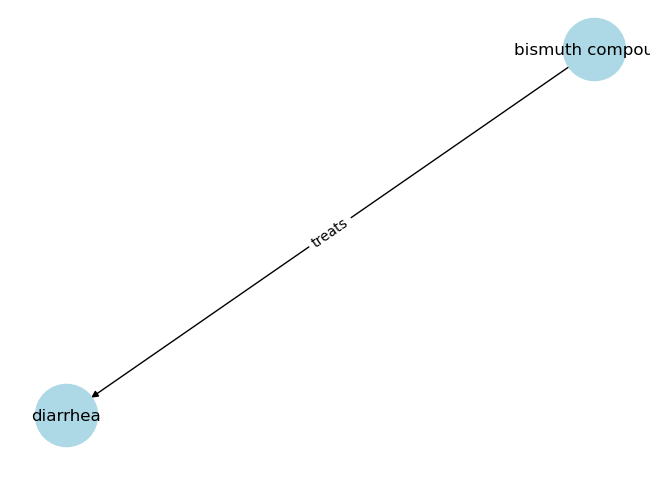

In [81]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()


In [112]:
doc = nlp("SARS-CoV-2 causes Corona and Remdesivir is used for treatment.")
for ent in doc.ents:
    print(ent.text, ent.label_)
    
# its detecting the pathogen and then medical conditions right 

SARS-CoV-2 PATHOGEN
Corona MEDICALCONDITION
Remdesivir MEDICINE


## Train using custom data sets

- Pipeline
1. Doc the custom json text data 
2. Create char_span
3. Train the model 
4. Build the knowledge graph for this.



## Custom dataset prep

In [193]:
{
  "dataset": [
    {
      "text": "Bordetella pertussis causes Whooping Cough. It is treated with Azithromycin.",
      "entities": [
        {"start": 0, "end": 20, "label": "PATHOGEN"},
        {"start": 28, "end": 42, "label": "MEDICAL_CONDITION"},
        {"start": 61, "end": 73, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Varicella-zoster virus causes Chickenpox. It is treated with Acyclovir.",
      "entities": [
        {"start": 0, "end": 22, "label": "PATHOGEN"},
        {"start": 30, "end": 40, "label": "MEDICAL_CONDITION"},
        {"start": 59, "end": 68, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Hepatitis B virus causes Hepatitis B. It is treated with Tenofovir.",
      "entities": [
        {"start": 0, "end": 18, "label": "PATHOGEN"},
        {"start": 26, "end": 37, "label": "MEDICAL_CONDITION"},
        {"start": 56, "end": 64, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Clostridium botulinum causes Botulism. It is treated with Antitoxin.",
      "entities": [
        {"start": 0, "end": 21, "label": "PATHOGEN"},
        {"start": 29, "end": 37, "label": "MEDICAL_CONDITION"},
        {"start": 56, "end": 65, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Treponema pallidum causes Syphilis. It is treated with Penicillin.",
      "entities": [
        {"start": 0, "end": 19, "label": "PATHOGEN"},
        {"start": 27, "end": 35, "label": "MEDICAL_CONDITION"},
        {"start": 54, "end": 64, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Plasmodium vivax causes Malaria. It is treated with Artemisinin.",
      "entities": [
        {"start": 0, "end": 17, "label": "PATHOGEN"},
        {"start": 25, "end": 32, "label": "MEDICAL_CONDITION"},
        {"start": 51, "end": 63, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Staphylococcus aureus causes Skin Infections. It is treated with Cephalexin.",
      "entities": [
        {"start": 0, "end": 21, "label": "PATHOGEN"},
        {"start": 29, "end": 44, "label": "MEDICAL_CONDITION"},
        {"start": 63, "end": 73, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Vibrio cholerae causes Cholera. It is treated with Doxycycline.",
      "entities": [
        {"start": 0, "end": 16, "label": "PATHOGEN"},
        {"start": 24, "end": 31, "label": "MEDICAL_CONDITION"},
        {"start": 50, "end": 62, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Corynebacterium diphtheriae causes Diphtheria. It is treated with Erythromycin.",
      "entities": [
        {"start": 0, "end": 26, "label": "PATHOGEN"},
        {"start": 34, "end": 44, "label": "MEDICAL_CONDITION"},
        {"start": 63, "end": 75, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Human papillomavirus causes Genital Warts. It is treated with Imiquimod.",
      "entities": [
        {"start": 0, "end": 21, "label": "PATHOGEN"},
        {"start": 29, "end": 41, "label": "MEDICAL_CONDITION"},
        {"start": 60, "end": 69, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Mycobacterium tuberculosis causes Tuberculosis. It is treated with Isoniazid.",
      "entities": [
        {"start": 0, "end": 26, "label": "PATHOGEN"},
        {"start": 34, "end": 46, "label": "MEDICAL_CONDITION"},
        {"start": 65, "end": 74, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Neisseria gonorrhoeae causes Gonorrhea. It is treated with Ceftriaxone.",
      "entities": [
        {"start": 0, "end": 22, "label": "PATHOGEN"},
        {"start": 30, "end": 39, "label": "MEDICAL_CONDITION"},
        {"start": 58, "end": 69, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Streptococcus pneumoniae causes Pneumonia. It is treated with Amoxicillin.",
      "entities": [
        {"start": 0, "end": 24, "label": "PATHOGEN"},
        {"start": 32, "end": 41, "label": "MEDICAL_CONDITION"},
        {"start": 60, "end": 71, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Salmonella typhi causes Typhoid Fever. It is treated with Ciprofloxacin.",
      "entities": [
        {"start": 0, "end": 16, "label": "PATHOGEN"},
        {"start": 24, "end": 37, "label": "MEDICAL_CONDITION"},
        {"start": 56, "end": 69, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Escherichia coli causes Urinary Tract Infection. It is treated with Nitrofurantoin.",
      "entities": [
        {"start": 0, "end": 17, "label": "PATHOGEN"},
        {"start": 25, "end": 49, "label": "MEDICAL_CONDITION"},
        {"start": 68, "end": 82, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Helicobacter pylori causes Peptic Ulcer. It is treated with Clarithromycin.",
      "entities": [
        {"start": 0, "end": 19, "label": "PATHOGEN"},
        {"start": 27, "end": 39, "label": "MEDICAL_CONDITION"},
        {"start": 58, "end": 73, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Borrelia burgdorferi causes Lyme Disease. It is treated with Doxycycline.",
      "entities": [
        {"start": 0, "end": 20, "label": "PATHOGEN"},
        {"start": 28, "end": 40, "label": "MEDICAL_CONDITION"},
        {"start": 59, "end": 71, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Influenza virus causes Flu. It is treated with Oseltamivir.",
      "entities": [
        {"start": 0, "end": 16, "label": "PATHOGEN"},
        {"start": 24, "end": 27, "label": "MEDICAL_CONDITION"},
        {"start": 46, "end": 57, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Candida albicans causes Thrush. It is treated with Fluconazole.",
      "entities": [
        {"start": 0, "end": 16, "label": "PATHOGEN"},
        {"start": 24, "end": 30, "label": "MEDICAL_CONDITION"},
        {"start": 49, "end": 60, "label": "MEDICINE"}
      ]
    },
    {
      "text": "Giardia lamblia causes Giardiasis. It is treated with Metronidazole.",
      "entities": [
        {"start": 0, "end": 15, "label": "PATHOGEN"},
        {"start": 23, "end": 33, "label": "MEDICAL_CONDITION"},
        {"start": 52, "end": 65, "label": "MEDICINE"}
      ]
    }
  ]
}

{'dataset': [{'text': 'Bordetella pertussis causes Whooping Cough. It is treated with Azithromycin.',
   'entities': [{'start': 0, 'end': 20, 'label': 'PATHOGEN'},
    {'start': 28, 'end': 42, 'label': 'MEDICAL_CONDITION'},
    {'start': 61, 'end': 73, 'label': 'MEDICINE'}]},
  {'text': 'Varicella-zoster virus causes Chickenpox. It is treated with Acyclovir.',
   'entities': [{'start': 0, 'end': 22, 'label': 'PATHOGEN'},
    {'start': 30, 'end': 40, 'label': 'MEDICAL_CONDITION'},
    {'start': 59, 'end': 68, 'label': 'MEDICINE'}]},
  {'text': 'Hepatitis B virus causes Hepatitis B. It is treated with Tenofovir.',
   'entities': [{'start': 0, 'end': 18, 'label': 'PATHOGEN'},
    {'start': 26, 'end': 37, 'label': 'MEDICAL_CONDITION'},
    {'start': 56, 'end': 64, 'label': 'MEDICINE'}]},
  {'text': 'Clostridium botulinum causes Botulism. It is treated with Antitoxin.',
   'entities': [{'start': 0, 'end': 21, 'label': 'PATHOGEN'},
    {'start': 29, 'end': 37, 'label': 'MEDICAL_CONDITION'},


In [209]:
dem_dataset = demo_stat['dataset']

text_arr = [ obj['text'] for obj in dem_dataset]

## Our model is not getting the pathogens properly 

Retrain with the existing dataset and then will check the accuracy

In [210]:
# creating the data set from trained ner model


for text in text_arr:
    doc = nlp(text)
    displacy.render(doc, style = 'ent', options = options)
    
    for ent in doc.ents:
        print(ent)

Bordetella pertussis
Whooping Cough


Varicella-zoster virus
Chickenpox


Hepatitis B virus
B.


Clostridium botulinum
Botulism


Treponema pallidum
.


Plasmodium vivax
.
Artemisinin


Staphylococcus aureus
Skin Infections


Vibrio cholerae
.
Doxycycline


Corynebacterium


Human papillomavirus
Warts


Bordetella pertussis
Whooping Cough


Varicella-zoster virus
Chickenpox


Hepatitis B virus
B.


Clostridium botulinum
Botulism


Treponema pallidum
.


Plasmodium vivax
.
Artemisinin


Staphylococcus aureus
Skin Infections


Vibrio cholerae
.
Doxycycline


Corynebacterium


Human papillomavirus
Warts


In [196]:
# Training the trf once again and then check 
from spacy.tokens import DocBin

nlp_bank = spacy.blank('en')

doc_bin = DocBin()

In [234]:
for training_eg in tqdm(dem_dataset):
    text = training_eg['text']
    labels = training_eg['entities']
    
    doc = nlp_bank.make_doc(text)
    ents = []
    
    for ele in labels:
        start, end, label = ele['start'], ele['end'], ele['label']
        span = doc.char_span(start, end, label = label, alignment_mode = "contract")
        if span is None:
            print(f"Skipping entity '{text[start:end]}'")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    
    doc.ents = filtered_ents
    doc_bin.add(doc)
    
doc_bin.to_disk("train1.spacy")
        

100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1895.35it/s]

Skipping entity 'h Azithromyc'
Skipping entity 'h Acyclov'
Skipping entity ' Tenofov'
Skipping entity 'h Antitox'
Skipping entity ' Penicilli'
Skipping entity 'h Cephalex'
Skipping entity ' Diphtheri'
Skipping entity 'th Erythromy'
Skipping entity 'h Imiquim'
Skipping entity 'h Azithromyc'
Skipping entity 'h Acyclov'
Skipping entity ' Tenofov'
Skipping entity 'h Antitox'
Skipping entity ' Penicilli'
Skipping entity 'h Cephalex'
Skipping entity ' Diphtheri'
Skipping entity 'th Erythromy'
Skipping entity 'h Imiquim'


In [219]:
# !pip install tokenizers==0.13.3


In [220]:
!python -m spacy init config config.cfg --lang en --pipeline ner --optimize efficiency -F


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [221]:
!python -m spacy train config.cfg --output ./ --paths.train ./train1.spacy --paths.dev ./train1.spacy --nlp.batch_size 100 --training.max_epochs 50


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ℹ Saving to output directory: .
ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

=========================== Initializing pipeline ===========================
[2025-05-17 14:05:16,210] [INFO] Set up nlp object from config
[2025-05-17 14:05:16,217] [INFO] Pipeline: ['tok2vec', 'ner']
[2025-05-17 14:05:16,218] [INFO] Created vocabulary
[2025-05-17 14:05:16,220] [INFO] Finished initializing nlp object
[2025-05-17 14:05:16,317] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     54.36   12.63    9.09   20.69    0.13
 42     200         68.81   2359.58   75.47   83.33   68.97    0.75
✔ Saved pipeline to output directory
model-last


In [222]:
nlp1 = spacy.load('model-best')



In [223]:
for text in text_arr:
    doc = nlp1(text)
    displacy.render(doc, style = 'ent', options = options)
    
    for ent in doc.ents:
        print(ent)

Bordetella pertussis
Whooping Cough


Varicella-zoster virus
Chickenpox


Hepatitis B virus


Clostridium botulinum
Botulism


/Users/ashwin.s/anaconda3/lib/python3.11/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


Plasmodium vivax
Artemisinin


Staphylococcus aureus
Skin Infections


Doxycycline


Bordetella pertussis
Whooping Cough


Varicella-zoster virus
Chickenpox


Hepatitis B virus


Clostridium botulinum
Botulism


Plasmodium vivax
Artemisinin


Staphylococcus aureus
Skin Infections


Doxycycline


## Analysis

- Even after training the model is not performing well.
- Therefore creating triplets using openAI/ gemini api 
- Split them into entity and then create the triplets 
- Construct the tree


In [227]:
# !pip install google-generativeai



In [229]:
import google.generativeai as genai

In [231]:
text_arr

['Bordetella pertussis causes Whooping Cough. It is treated with Azithromycin.',
 'Varicella-zoster virus causes Chickenpox. It is treated with Acyclovir.',
 'Hepatitis B virus causes Hepatitis B. It is treated with Tenofovir.',
 'Clostridium botulinum causes Botulism. It is treated with Antitoxin.',
 'Treponema pallidum causes Syphilis. It is treated with Penicillin.',
 'Plasmodium vivax causes Malaria. It is treated with Artemisinin.',
 'Staphylococcus aureus causes Skin Infections. It is treated with Cephalexin.',
 'Vibrio cholerae causes Cholera. It is treated with Doxycycline.',
 'Corynebacterium diphtheriae causes Diphtheria. It is treated with Erythromycin.',
 'Human papillomavirus causes Genital Warts. It is treated with Imiquimod.',
 'Bordetella pertussis causes Whooping Cough. It is treated with Azithromycin.',
 'Varicella-zoster virus causes Chickenpox. It is treated with Acyclovir.',
 'Hepatitis B virus causes Hepatitis B. It is treated with Tenofovir.',
 'Clostridium botul

In [237]:
import google.generativeai as genai

# Initialize the Gemini model
model = genai.GenerativeModel(model_name="gemini-1.5-flash")  # or "gemini-1.5-pro" for better accuracy

# Defined a response model

def create_response(text_input):
    prompt = f"""
You are a biomedical researcher. Extract named entities from the given input text. Focus on:
- MEDICINE
- MEDICAL_CONDITION
- PATHOGEN

Respond in the following JSON format only:
{{
  "text_input": "{text_input}",
  "entities": [
    {{"text": "<entity>", "label": "MEDICINE" | "MEDICAL_CONDITION" | "PATHOGEN"}},
    ...
  ]
}}

Input: {text_input}
"""
    response = model.generate_content(prompt)
    return response.text


In [242]:
# text_5 = text_arr[0:5]

# for text_input in text_arr:
#     response = create_response(text_input)
#     print(response)

In [243]:
refined_data = {
  "dataset": [
    {
      "text_input": "Bordetella pertussis causes Whooping Cough. It is treated with Azithromycin.",
      "entities": [
        {"text": "Bordetella pertussis", "label": "PATHOGEN"},
        {"text": "Whooping Cough", "label": "MEDICAL_CONDITION"},
        {"text": "Azithromycin", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Varicella-zoster virus causes Chickenpox. It is treated with Acyclovir.",
      "entities": [
        {"text": "Varicella-zoster virus", "label": "PATHOGEN"},
        {"text": "Chickenpox", "label": "MEDICAL_CONDITION"},
        {"text": "Acyclovir", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Hepatitis B virus causes Hepatitis B. It is treated with Tenofovir.",
      "entities": [
        {"text": "Hepatitis B virus", "label": "PATHOGEN"},
        {"text": "Hepatitis B", "label": "MEDICAL_CONDITION"},
        {"text": "Tenofovir", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Clostridium botulinum causes Botulism. It is treated with Antitoxin.",
      "entities": [
        {"text": "Clostridium botulinum", "label": "PATHOGEN"},
        {"text": "Botulism", "label": "MEDICAL_CONDITION"},
        {"text": "Antitoxin", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Treponema pallidum causes Syphilis. It is treated with Penicillin.",
      "entities": [
        {"text": "Treponema pallidum", "label": "PATHOGEN"},
        {"text": "Syphilis", "label": "MEDICAL_CONDITION"},
        {"text": "Penicillin", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Plasmodium vivax causes Malaria. It is treated with Artemisinin.",
      "entities": [
        {"text": "Plasmodium vivax", "label": "PATHOGEN"},
        {"text": "Malaria", "label": "MEDICAL_CONDITION"},
        {"text": "Artemisinin", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Staphylococcus aureus causes Skin Infections. It is treated with Cephalexin.",
      "entities": [
        {"text": "Staphylococcus aureus", "label": "PATHOGEN"},
        {"text": "Skin Infections", "label": "MEDICAL_CONDITION"},
        {"text": "Cephalexin", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Vibrio cholerae causes Cholera. It is treated with Doxycycline.",
      "entities": [
        {"text": "Vibrio cholerae", "label": "PATHOGEN"},
        {"text": "Cholera", "label": "MEDICAL_CONDITION"},
        {"text": "Doxycycline", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Corynebacterium diphtheriae causes Diphtheria. It is treated with Erythromycin.",
      "entities": [
        {"text": "Corynebacterium diphtheriae", "label": "PATHOGEN"},
        {"text": "Diphtheria", "label": "MEDICAL_CONDITION"},
        {"text": "Erythromycin", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Human papillomavirus causes Genital Warts. It is treated with Imiquimod.",
      "entities": [
        {"text": "Human papillomavirus", "label": "PATHOGEN"},
        {"text": "Genital Warts", "label": "MEDICAL_CONDITION"},
        {"text": "Imiquimod", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Mycobacterium tuberculosis causes Tuberculosis. It is treated with Isoniazid.",
      "entities": [
        {"text": "Mycobacterium tuberculosis", "label": "PATHOGEN"},
        {"text": "Tuberculosis", "label": "MEDICAL_CONDITION"},
        {"text": "Isoniazid", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Neisseria gonorrhoeae causes Gonorrhea. It is treated with Ceftriaxone.",
      "entities": [
        {"text": "Neisseria gonorrhoeae", "label": "PATHOGEN"},
        {"text": "Gonorrhea", "label": "MEDICAL_CONDITION"},
        {"text": "Ceftriaxone", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Streptococcus pneumoniae causes Pneumonia. It is treated with Amoxicillin.",
      "entities": [
        {"text": "Streptococcus pneumoniae", "label": "PATHOGEN"},
        {"text": "Pneumonia", "label": "MEDICAL_CONDITION"},
        {"text": "Amoxicillin", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Salmonella typhi causes Typhoid Fever. It is treated with Ciprofloxacin.",
      "entities": [
        {"text": "Salmonella typhi", "label": "PATHOGEN"},
        {"text": "Typhoid Fever", "label": "MEDICAL_CONDITION"},
        {"text": "Ciprofloxacin", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Escherichia coli causes Urinary Tract Infection. It is treated with Nitrofurantoin.",
      "entities": [
        {"text": "Escherichia coli", "label": "PATHOGEN"},
        {"text": "Urinary Tract Infection", "label": "MEDICAL_CONDITION"},
        {"text": "Nitrofurantoin", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Helicobacter pylori causes Peptic Ulcer. It is treated with Clarithromycin.",
      "entities": [
        {"text": "Helicobacter pylori", "label": "PATHOGEN"},
        {"text": "Peptic Ulcer", "label": "MEDICAL_CONDITION"},
        {"text": "Clarithromycin", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Borrelia burgdorferi causes Lyme Disease. It is treated with Doxycycline.",
      "entities": [
        {"text": "Borrelia burgdorferi", "label": "PATHOGEN"},
        {"text": "Lyme Disease", "label": "MEDICAL_CONDITION"},
        {"text": "Doxycycline", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Influenza virus causes Flu. It is treated with Oseltamivir.",
      "entities": [
        {"text": "Influenza virus", "label": "PATHOGEN"},
        {"text": "Flu", "label": "MEDICAL_CONDITION"},
        {"text": "Oseltamivir", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Candida albicans causes Thrush. It is treated with Fluconazole.",
      "entities": [
        {"text": "Candida albicans", "label": "PATHOGEN"},
        {"text": "Thrush", "label": "MEDICAL_CONDITION"},
        {"text": "Fluconazole", "label": "MEDICINE"}
      ]
    },
    {
      "text_input": "Giardia lamblia causes Giardiasis. It is treated with Metronidazole.",
      "entities": [
        {"text": "Giardia lamblia", "label": "PATHOGEN"},
        {"text": "Giardiasis", "label": "MEDICAL_CONDITION"},
        {"text": "Metronidazole", "label": "MEDICINE"}
      ]
    }
  ]
}

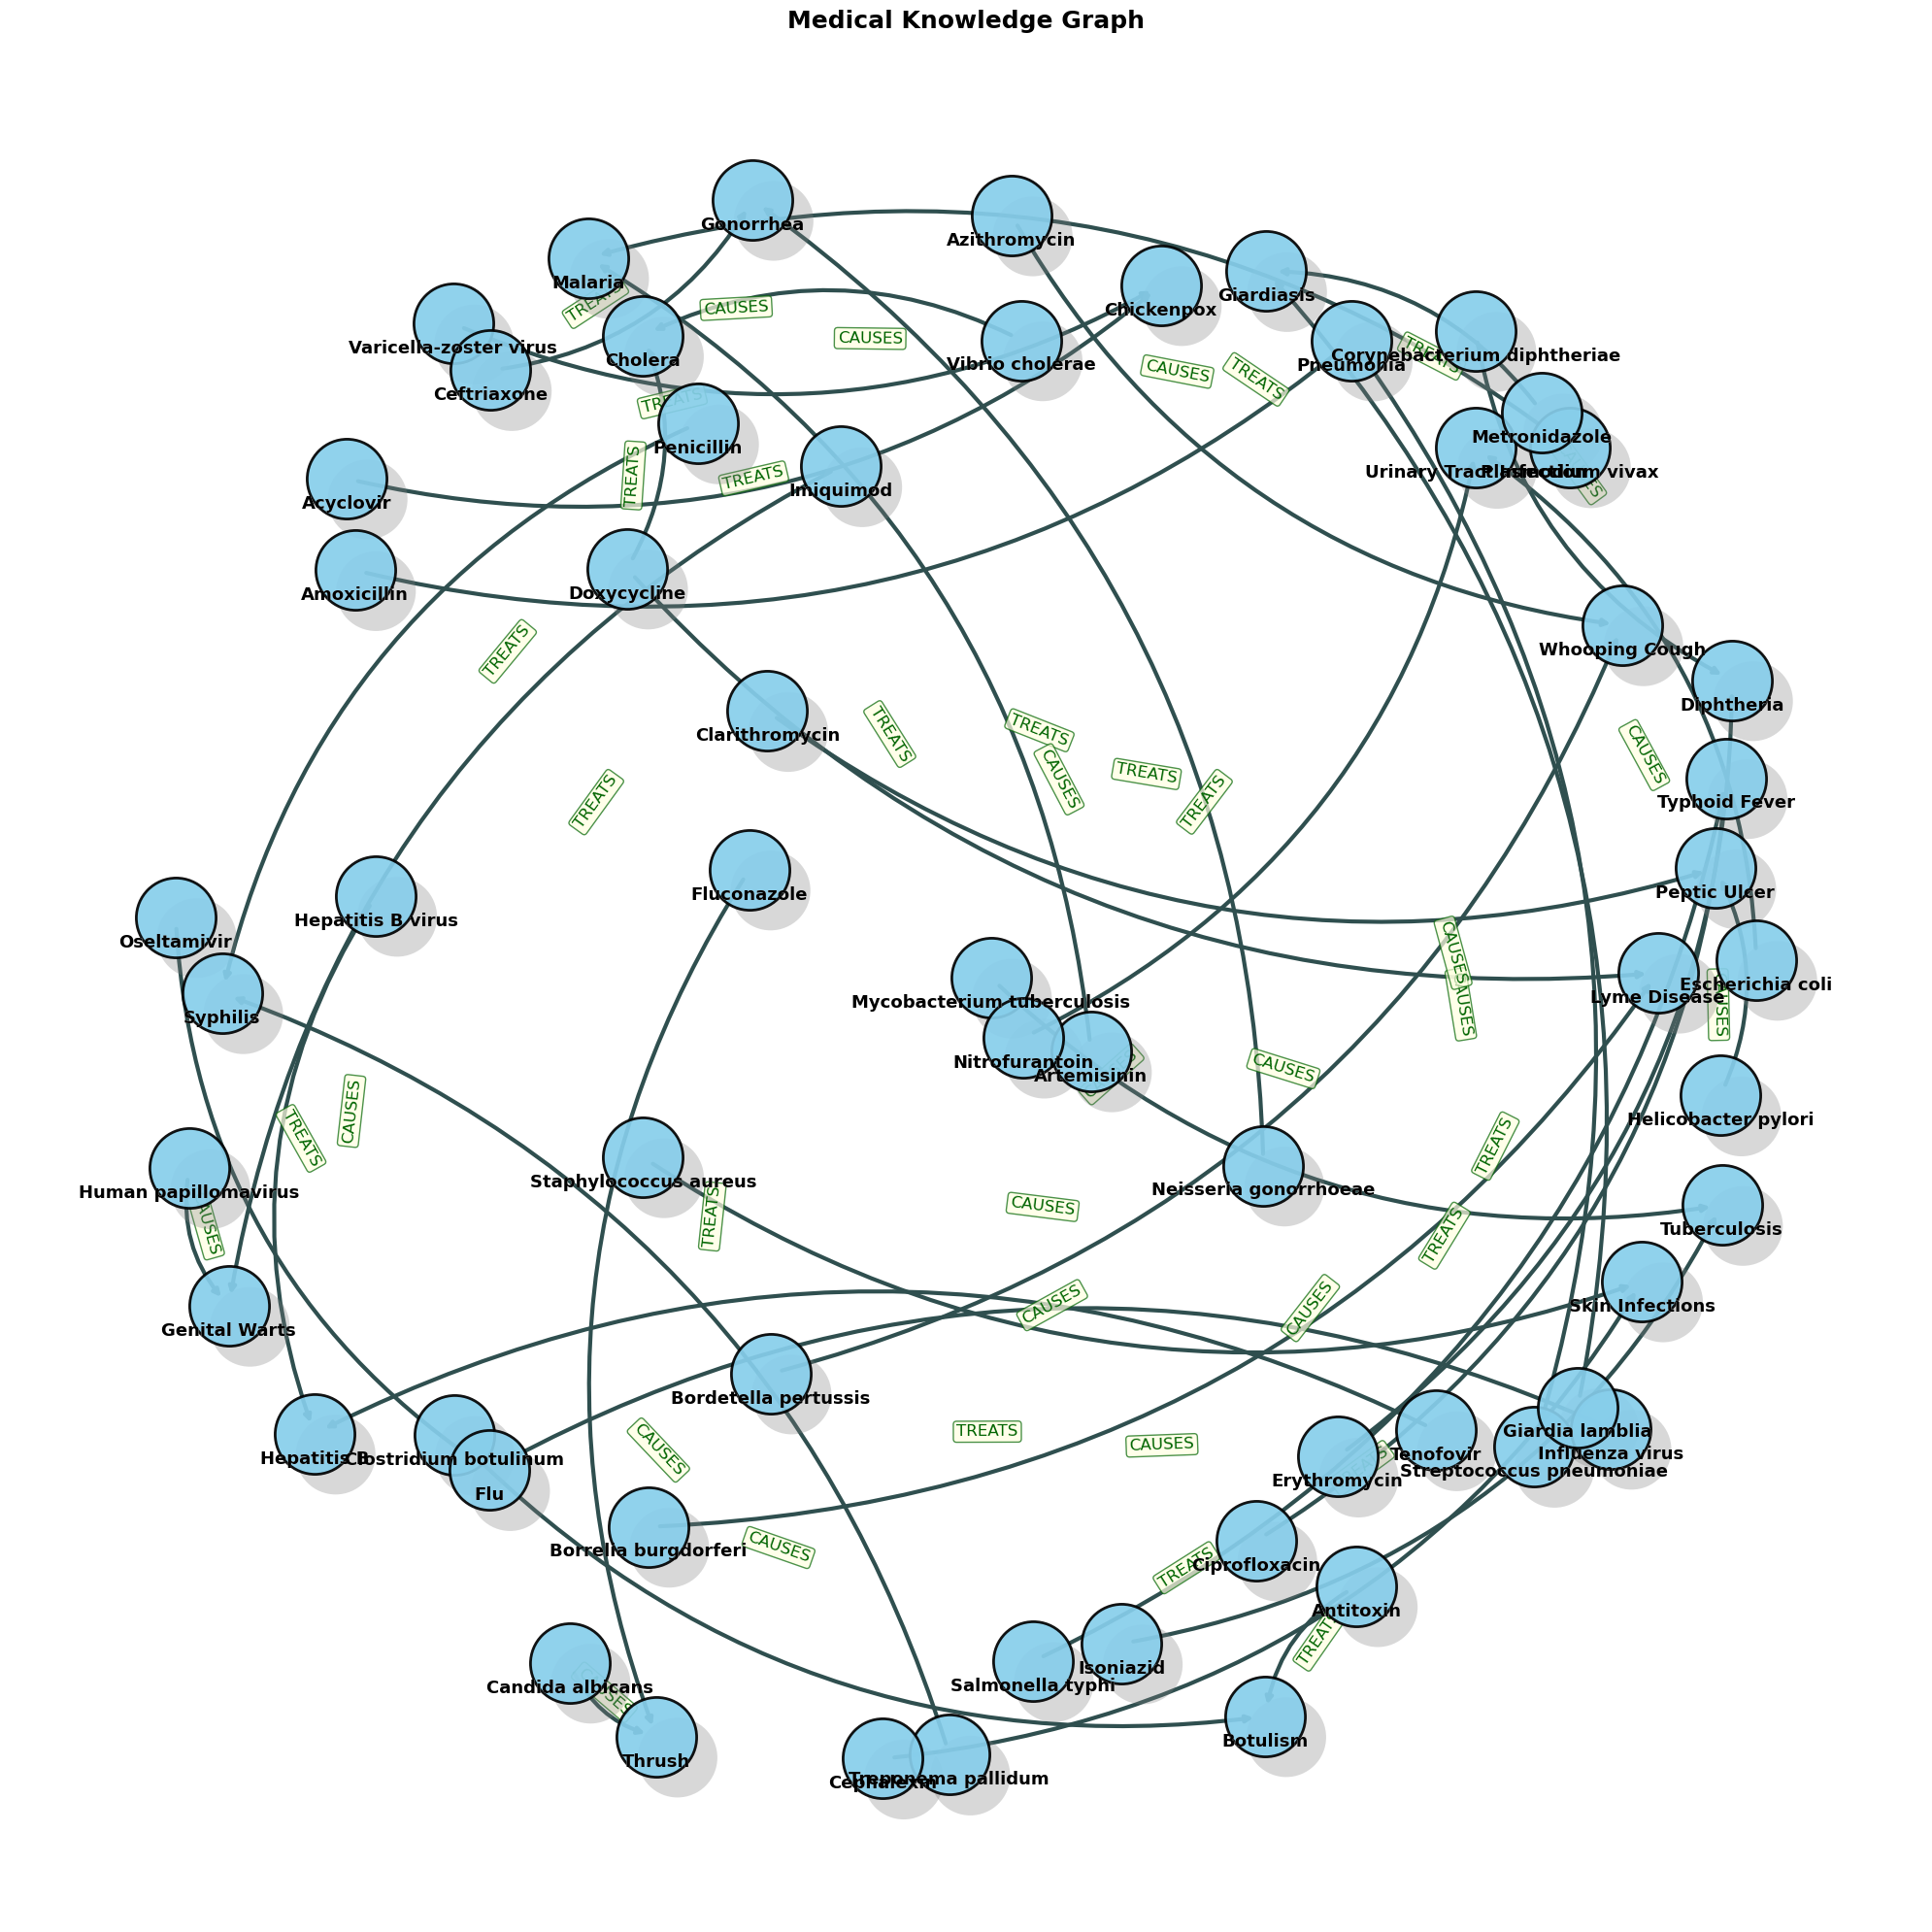

In [260]:
import networkx as nx
import matplotlib.pyplot as plt

data_input = refined_data['dataset']

def extract_triplets(data_input):
    triplets = []

    for obj in data_input:
        medicine = None
        condition = None
        pathogen = None

        entities = obj['entities']
        for ent in entities:
            if ent["label"] == "MEDICINE":
                medicine = ent['text']
            elif ent['label'] == 'MEDICAL_CONDITION':
                condition = ent['text']
            elif ent['label'] == "PATHOGEN":
                pathogen = ent['text']

        if medicine and condition:
            triplets.append((medicine, "TREATS", condition))

        if pathogen and condition:
            triplets.append((pathogen, "CAUSES", condition))

    return triplets

# Extract all triplets
all_triplets = extract_triplets(data_input)

# Build the graph
G = nx.DiGraph()
for subj, rel, obj in all_triplets:
    G.add_node(subj)
    G.add_node(obj)
    G.add_edge(subj, obj, label=rel)

# Visualize

pos = nx.spring_layout(G, k=1, seed=42)

plt.figure(figsize=(20, 20))

# Draw shadow nodes first for depth
shadow_pos = {k: (v[0]+0.025, v[1]-0.025) for k, v in pos.items()}
nx.draw_networkx_nodes(
    G, shadow_pos,
    node_color='gray',
    node_size=3500,
    edgecolors='none',
    alpha=0.3
)

# Draw main nodes
nx.draw_networkx_nodes(
    G, pos,
    node_color='skyblue',
    node_size=3500,
    edgecolors='black',
    linewidths=2,
    alpha=0.92
)

# Draw edges with enhanced style
nx.draw_networkx_edges(
    G, pos,
    edge_color='darkslategray',
    arrows=True,
    arrowstyle='-|>',
    connectionstyle='arc3,rad=0.25',
    width=3
)

# Draw node labels with shadow effect for contrast
for node, (x, y) in pos.items():
    plt.text(x, y-0.03, node, fontsize=13, fontweight='bold', color='white', ha='center', va='center', zorder=2)
    plt.text(x, y-0.03, node, fontsize=13, fontweight='bold', color='black', ha='center', va='center', zorder=3)

# Draw edge labels with a background box for readability
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='darkgreen',
    font_size=12,
    label_pos=0.6,
    bbox=dict(boxstyle='round,pad=0.2', fc='lightyellow', ec='darkgreen', lw=1, alpha=0.7)
)

plt.title("Medical Knowledge Graph", fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()